# Wine

---
embed-resources: true
---

## Introduction

We would like to create an AI Sommelier that would rate the quality of wine based on physicochemical data. Normally wine quality is determined by trained professionals, but it would be cheaper to gather chemical data on the wine and then use machine learning to categorize its quality. The purpose of this report is to determine if such a model would be effective and useful.

## Methods

In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import numpy as np
from joblib import dump

### Data

In [2]:
# load data
wine_train = pd.read_parquet(
    "https://cs307.org/lab/data/wine-train.parquet",
)
wine_test = pd.read_parquet(
    "https://cs307.org/lab/data/wine-test.parquet",
)

# create X and y for train
X_train = wine_train.drop("quality", axis=1)
y_train = wine_train["quality"]

# create X and y for test
X_test = wine_test.drop("quality", axis=1)
y_test = wine_test["quality"]

Each observation in the dataset contains information about a particular Portuguese Vinho Verde wine. The data was sourced from UC Irvine Machine Learning Repository. The data dictionary is detailed below.

### Response
**`quality`**
- [int64] the quality of the wine based on evaluation by a minimum of three sensory assessors (using blind tastes), which graded the wine in a scale that ranges from 0 (very bad) to 10 (excellent)

### Features
**`color`**
- [object] the (human perceivable) color of the wine, red or white

**`fixed acidity`**
- [float64] grams of tartaric acid per cubic decimeter

**`volatile acidity`**
- [float64] grams of acetic acid per cubic decimeter

**`citric acid`**
- [float64] grams of citric acid per cubic decimeter

**`residual sugar`**
- [float64] grams of residual sugar per cubic decimeter

**`chlorides`**
- [float64] grams of sodium chloride cubic decimeter

**`free sulfur dioxide`**
- [float64] milligrams of free sulfur dioxide per cubic decimeter

**`total sulfur dioxide`**
- [float64] milligrams of total sulfur dioxide per cubic decimeter

**`density`**
- [float64] the total density of the wine in grams per cubic centimeter

**`pH`**
- [float64] the acidity of the wine measured using pH

**`sulphates`**
- [float64] grams of potassium sulphate cubic decimeter

**`alcohol`**
- [float64] percent alcohol by volume

In [3]:
# summary statistics
wine_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
2556,7.6,0.23,0.64,12.9,0.033,54.0,170.0,0.99800,3.00,0.53,8.8,5,white
1237,NaN,0.75,0.01,2.2,0.059,11.0,18.0,0.99242,3.39,0.40,NaN,6,red
303,7.4,0.67,0.12,1.6,0.186,5.0,21.0,0.99600,3.39,0.54,9.5,5,red
1583,6.4,0.18,0.74,NaN,0.046,54.0,168.0,0.99780,3.58,0.68,10.1,5,white
4697,6.7,0.35,0.32,9.0,0.032,29.0,113.0,0.99188,3.13,0.65,12.9,7,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,6.6,0.32,0.22,16.7,0.046,38.0,133.0,0.99790,3.22,0.67,10.4,6,white
905,9.2,0.58,0.20,3.0,0.081,15.0,115.0,0.99800,3.23,0.59,9.5,5,red
247,8.2,0.60,0.17,2.3,0.072,11.0,73.0,0.99630,3.20,0.45,9.3,5,red
2707,6.5,0.23,0.36,16.3,0.038,43.0,133.0,0.99924,3.26,0.41,8.8,5,white


The dataset has 4157 samples and 12 features.

In [4]:
# | echo: False
pd.concat([pd.DataFrame(wine_train.isna().sum(), columns=['missing']), pd.DataFrame(wine_train.isna().sum() / len(wine_train), columns=['% missing'])], axis=1)

,missing,% missing
fixed acidity,170,0.040895
volatile acidity,0,0.000000
citric acid,199,0.047871
residual sugar,240,0.057734
chlorides,0,0.000000
free sulfur dioxide,24,0.005773
total sulfur dioxide,0,0.000000
density,0,0.000000
pH,236,0.056772
sulphates,223,0.053644


About 7 variables contain around or less than 5% missing values and 6 variables contain no missing values.

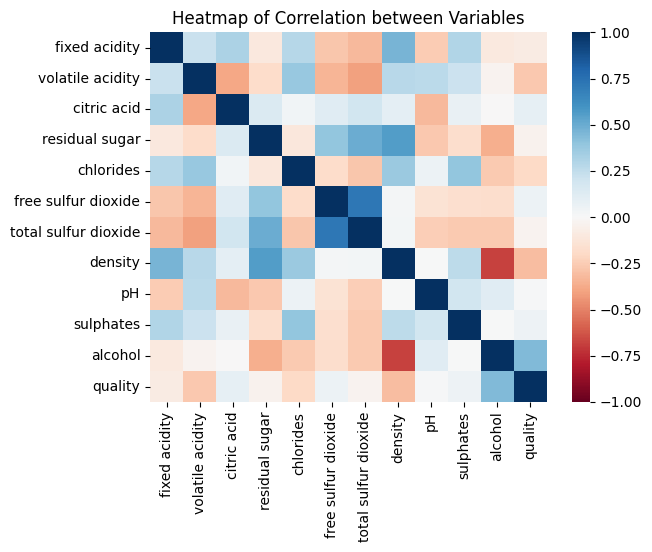

In [5]:
# | echo: False
# exploratory visualization
sns.heatmap(wine_train.corr(numeric_only=True), vmin=-1, vmax=1, cmap='RdBu')
plt.title("Heatmap of Correlation between Variables")
plt.show()

We see that quality has a few weak negative correlations and one weak positive correlation.

### Models

In [7]:
# process data for ML
numeric_features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
categorical_features = ['color']
features = numeric_features + categorical_features
target = 'quality'

In [8]:
# train models
numeric_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
    ]
)

categorical_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist')),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, numeric_features),
        ("categoric", categorical_pipeline, categorical_features),
    ],
    remainder='drop'
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('estimator', KNeighborsClassifier()),
    ]
)

We will use a KNeighborsClassifier model to predict the target variable. We will impute missing values, scale numeric variables, and one-hot encode categorical variables.

In [9]:
param_grid = [{
    "estimator__n_neighbors": range(10, 70, 1),
    "estimator__metric": ["euclidean", "manhattan", "chebyshev", "minkowski"],
    "estimator__weights": ["uniform", "distance"],
}]

model = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_error', refit=True)
_ = model.fit(X_train, y_train)

/Users/ryansponzilli/Developer/UIUC/cs307/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [17]:
model.best_params_

{'estimator__metric': 'manhattan',
 'estimator__n_neighbors': 46,
 'estimator__weights': 'distance'}

In [18]:
train_mae = model.best_score_
train_mae

np.float64(-0.4228964176617606)

After parameter tuning with cross validation, the best KNeighborsClassifier model uses 46 neighbors, mahatten distance, and distance weights. It acheives a train MAE of 0.422.

## Results

In [19]:
# report model metrics
test_mae = mean_absolute_error(y_test, model.predict(X_test))
test_mae

0.4

The test data mean absolute error is 0.4.

In [20]:
# serialize model
dump(model, 'wine.joblib')

['wine.joblib']

## Discussion

I would recommend that this model be put into practice. Considering that the target `Quality` is on a 10 point scale and that the mean absolute error of the test dataset is 0.4, the wine quality prediction is quite close. Our AI sommelier would be able to rate different wines very close to how humans do, and I suspect that not every human wine quality rater rates it the exact same as each other, so if you think about it like that, our AI sommelier is just another person ranking the wine, and they will likely not be exactly the same as the other rankers, but pretty close. There are no major disadvantages to putting this model into practice; no customer will be the wiser if their wine is rated a half point off from what a trained professional might say. Furthermore, it is advantageous for any business to be able to use an AI sommelie because it would be substantially cheaper than hiring a trained professional.

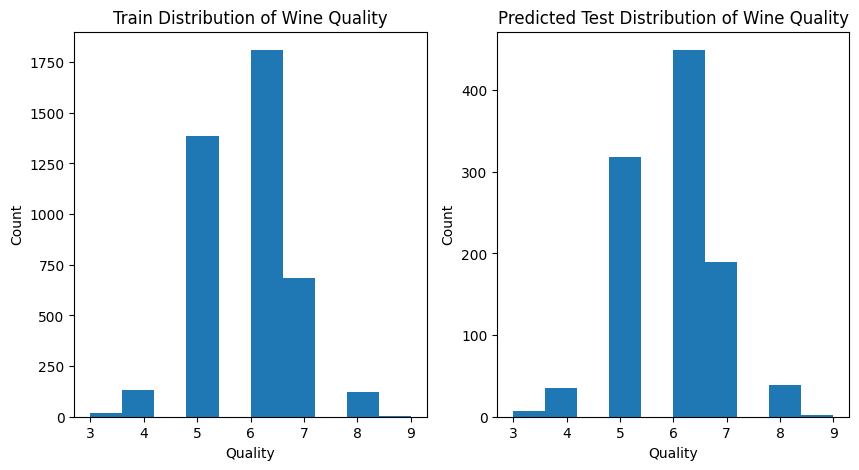

In [21]:
# | echo: False
# | lightbox: True

# summary figure
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist(y_train)
ax[0].set_title("Train Distribution of Wine Quality")
ax[0].set_xlabel("Quality")
ax[0].set_ylabel("Count")
ax[1].hist(y_test)
ax[1].set_title("Predicted Test Distribution of Wine Quality")
ax[1].set_xlabel("Quality")
ax[1].set_ylabel("Count")
plt.show()


This figure demonstrates that the model predicts a very similar distribution of wine quality as the training dataset contains.